# 10-14.프로젝트 : CIFAR-10 이미지 생성하기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


## STEP 1. 작업환경 구성하기
 > mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples <br>
 > mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints <br>
 > mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

## STEP 2. 데이터셋 구성하기

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [6]:
# 각 픽셀은 0~255 사이의 정숫값을 가짐을 확인
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [7]:
# 학습에 사용할 train_x의 이미지를 -1, 1로 정규화

train_x = (train_x - 127.5) / 127.5 # 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줌.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [8]:
train_x.shape # train 데이터 형태 확인

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

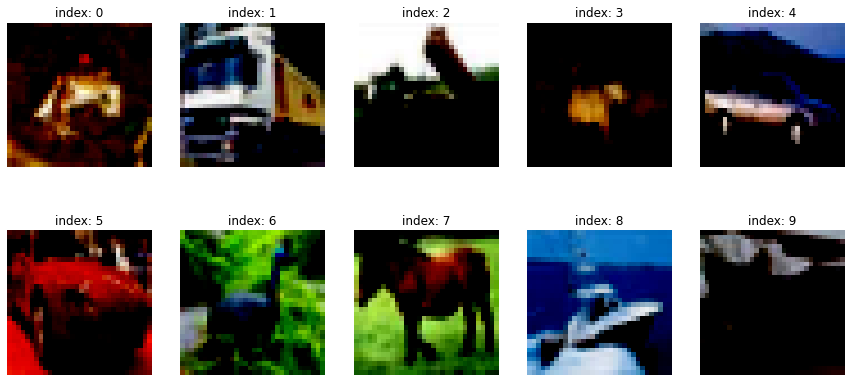

In [11]:
# 로드한 학습 데이터를 시각화를 통해 확인

# for문 활용 10개 데이터 보기

plt.figure(figsize=(15, 7))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

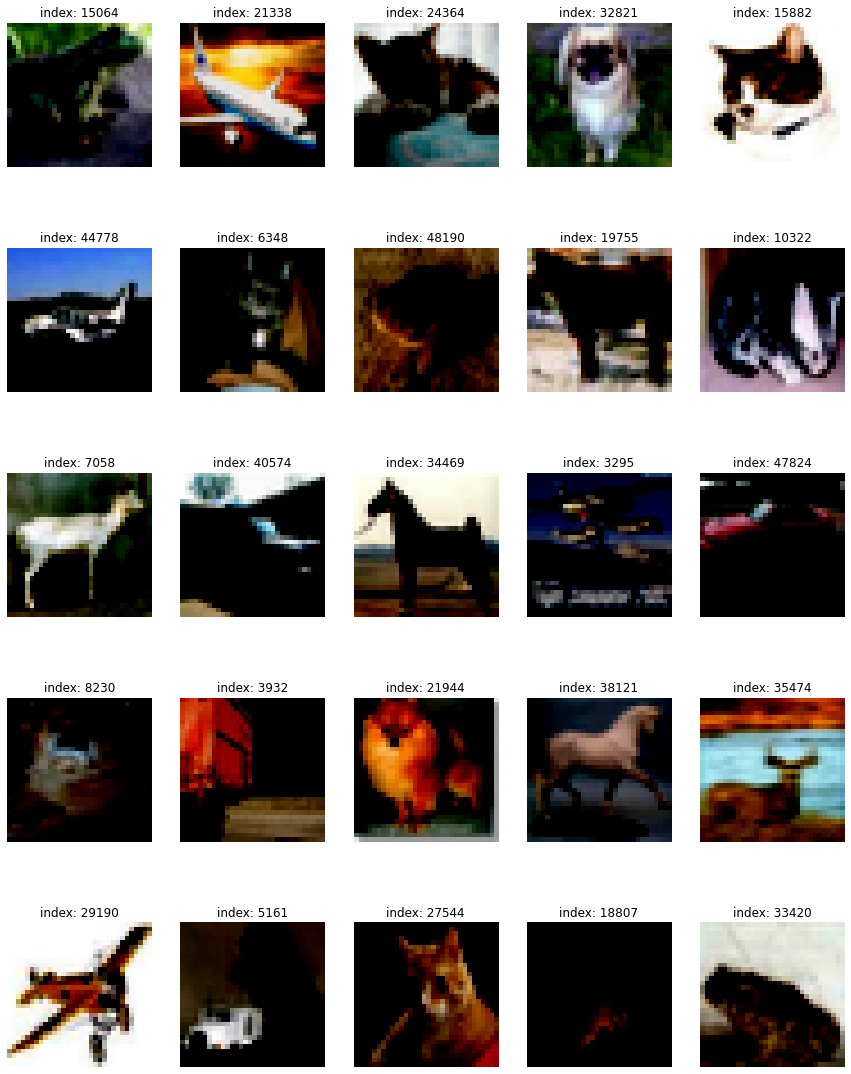

In [12]:
# for 문을 활용해서 이미지 25개를 5x5 의 배열로 단, 모든 이미지는 train_images에서 랜덤으로 추출

plt.figure(figsize=(15, 20))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

In [13]:
# tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성

# 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정
BUFFER_SIZE = 50000
BATCH_SIZE = 256

# train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 3. 생성자 모델 구현하기

### ake_generator_model 함수

* tf.keras.Sequential()로 모델을 시작한 후 레이어를 차곡차곡 쌓음.
* **Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층**, 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (8, 8, 256) → (16, 16, 64) → (32, 32, 3) 순으로 이미지를 키움. 여기서 최종 사이즈인 (32, 32, 3)은 우리가 준비했던 데이터셋과 형상이 동일
* **BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화** 시켜줌. 
* **중간층들의 활성화 함수는 모두 LeakyReLU**를 사용. 
* **마지막 층에는 활성화 함수로 tanh를 사용 - 이는 우리가 -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함**

In [14]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))  # 입력 값으로 (batch_size, 100) 형태의 노이즈벡터 받아
                      # 7*7*256 = 12544개의 노드를 가진 Dense 레이어를 거치며 (batch_size, 12544) 형태의 벡터가 됨.
    
    model.add(layers.BatchNormalization())  # 가중치 값을 정규화
    
    model.add(layers.LeakyReLU())   # 중간층들의 활성화 함수는 모두 LeakyReLU

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))   # Convolutional 연산 가능하도록 1차원 벡터를 3차원 형태(8,8,256)로 변환 시킴.

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())  
    model.add(layers.LeakyReLU())   

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())   
    model.add(layers.LeakyReLU())  

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh')) # 활성화 함수로 tanh를 사용 - -1 ~ 1 이내의 값으로 픽셀 값을 정규화

    return model

In [15]:
# 생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용인 summary를 출력
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [16]:
# shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성
noise = tf.random.normal([1, 100])

텐서플로우 2.0 이후 버전에서는 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성 (내부적으로는 생성자의 call 함수가 호출)<br>
지금은 학습하는 중이 아니니 **training=False를 설정** - **Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에** training=False을 주어야 올바른 결과를 얻을 수 있음

In [17]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻

### 이미지 시각화
matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정 (32, 32) shape의 이미지를 꺼낼 수 있도록

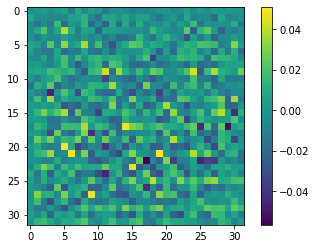

In [18]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## STEP 4. 판별자 모델 구현하기
* 판별자는 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야 함.<br>
그렇다면 입력은 (32, 32, 3) 크기의 이미지가, 출력은 단 하나의 숫자(진짜라고 판단하는 정도)가 될 것.

### 판별자 또한 make_discriminator_model 함수로 구현
* Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나감. 첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 줄어
* 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x128 = 8192 벡터로 변환 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할
* 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력.

In [19]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())  #  3차원 이미지를 1차원으로 쭉 펴서 8x8x128 = 8192  즉 즉 (1, 8192)벡터로 변환

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [20]:
# 판별 모델을 discriminator라는 변수 이름으로 생성하고, 모델 세부 내용인 summary를 출력
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [21]:
# 가짜 이미지를 판별자(노이즈 벡터로 만든)에 입력시키면 어떤 결과가 나올지..
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00441252]], dtype=float32)>

텐서플로우의 텐서 형태로 출력이 됨. 이 값 또한 아직은 아무런 의미가 없는 값

## STEP 5. 손실함수와 최적화 함수 구현하기

### GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용
> 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰임
> 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것임.

tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정. 따라서 from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있음.

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용
* fake_output : 생성자가 생성한 Fake Image를 구분자에 입력 시켜서 판별된 값, 즉 D(fake_image)
* real_output : 기본에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

### generator_loss
* generator_loss는 fake_output가 1에 가까워지기를 바라므로 tf.ones_like와의 교차 엔트로피값을 계산<br>
* f.ones_like()와 tf.zeros_like() 함수를 활용 - 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용<br>
즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가짐.

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss
discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산<br>
real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교할 수 있음.

최종 discriminator_loss 값은 이 둘을 더한 값.

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy
판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요, 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용함.

real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적.<br>
fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻.

In [25]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

discriminator_accuracy() 함수에서 사용된 tensorflow 함수들의 역할을 순차적으로 예를 들어 정리하면 다음과 같음

만일 real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 이라면
* (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> tf.Tensor([False, False, True, True])
* (2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - >> tf.Tensor([0.0, 0.0, 1.0, 1.0])
* (3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> 0.5

### 최적화 함수(optimizer)

Adam 최적화 기법 을 활용
* 중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천
* 중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## STEP 6. 훈련과정 상세 기능 구현하기

### 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인
* 샘플은 한 번에 16장을 생성
* 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어 둠

In [27]:
# 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 둠.
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### train_step 함수 - 하나의 미니 배치 당 진행할 함수
* (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
* (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
* (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
* (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
* (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
* (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
* (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
* (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
* (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
* (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [28]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

이렇게 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들기
아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있음.

In [35]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들기

In [36]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정
def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

정기적으로 모델을 저장하기 위한 checkpoint를 만들기.<br>
tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해 주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있음.<br>
모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적.<br>
checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장. 정확히는 생성자와 판별자가 학습한 모델 가중치를 저장하는 것.<br>
checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints 라는 디렉토리를 사용.

In [37]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기

In [38]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [40]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

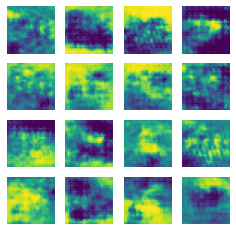

Time for training : 752 sec


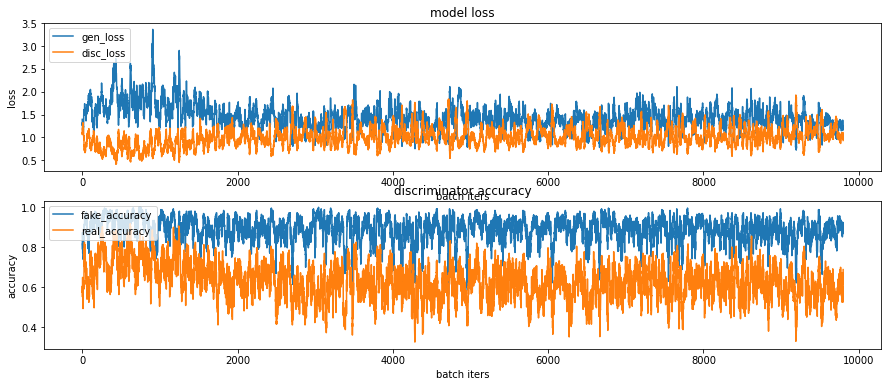

CPU times: user 12min 54s, sys: 1min 19s, total: 14min 13s
Wall time: 12min 32s


In [41]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있음

생성자가 만든 Fake Image에 대한 판별자의 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있다면, 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 뜻

### 학습과정 시각화하기

In [45]:
# 학습이 끝난 후 우리가 생성했던 샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만듬.

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


-rw-r--r-- 1 root root 1399393 Feb  8 11:41 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


## STEP 8. (optional) GAN 훈련 과정 개선하기

학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생김.<br>
checkpoint 모듈을 이용해 모델을 저장해 것을 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있음.

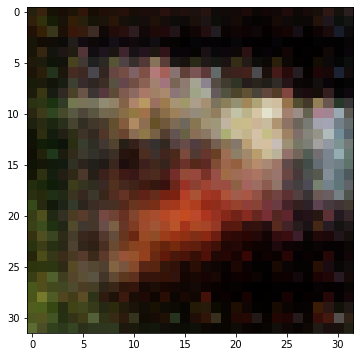

In [46]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## 후기

gif 이미지 생성되었는데 주피터 노트북에 바로 보여지지 않음.<br>
구분을 위한 것인데 잘 만들어진건지 알 수 없음.<br>
학습과정을 시각화한 loss, accuracy 그래프의 수치 변화가 정확히 어떤 의미인지 잘 모르겠음.<br>
아직도 모델 개선은 어렵고 과제 제출 만으로도 벅참. ㅠ_ㅠ